In [11]:
#pip install shap

In [12]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit

#feature selection
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.base import BaseEstimator, TransformerMixin

#outlier
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

#pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

#
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import pickle

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max.columns", None)


In [13]:
df = pd.read_csv('heart.csv')

In [14]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [15]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [16]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=12)
for train_index, test_index in split.split(df, df['Sex']):
    strat_train_sets = df.loc[train_index]
    strat_test_sets = df.loc[test_index]

In [17]:
y_heart = strat_train_sets[['HeartDisease']].copy()
heart = strat_train_sets.drop('HeartDisease', axis=1)

In [18]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 734 entries, 865 to 737
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    object 
 2   ChestPainType   734 non-null    object 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    object 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    object 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 68.8+ KB


# prepros

## Feature Selection

In [19]:
#calsifikasi 
num = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categoric =  ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

### Numeric

In [20]:
numeric = heart[num]

In [21]:
model_select = RandomForestRegressor()
model_select.fit(numeric, y_heart)

RandomForestRegressor()

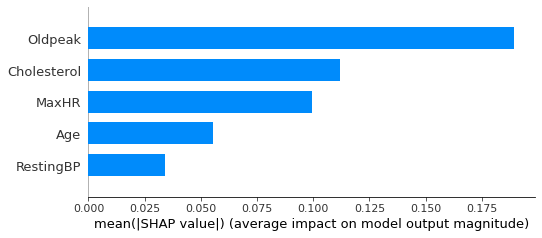

In [22]:
shap_values = shap.TreeExplainer(model_select).shap_values(numeric)
shap.summary_plot(shap_values, numeric, plot_type="bar")

### Categoric

In [23]:
heart_cat = heart[categoric]

In [24]:
oe = OrdinalEncoder()
heart_ordinal = oe.fit_transform(heart_cat)

In [25]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(heart_ordinal, y_heart)

SelectKBest(k='all', score_func=<function chi2 at 0x7feda0fc8670>)

In [26]:
fs.scores_

array([ 14.09977343, 113.53058459,  43.06882327,   1.03905407,
       116.70879888,  71.18363871])

In [27]:
cols = fs.get_support(indices=True)
list_col_cat = (heart_cat.iloc[:, cols].columns)
list_score = [fs.scores_[val] for val in range(len(fs.scores_))]

score = {'columns' : list_col_cat, 'score' : list_score}

score_df = pd.DataFrame(score)

In [28]:
score_df.sort_values(by='score', ascending=False)

,columns,score
4,ExerciseAngina,116.708799
1,ChestPainType,113.530585
5,ST_Slope,71.183639
2,FastingBS,43.068823
0,Sex,14.099773
3,RestingECG,1.039054


In [29]:
fig = px.histogram(score_df.sort_values(by='score', ascending=False), x='columns', y = 'score')
fig.show()

note : 
1. untuk data categori dapat dilihat pada RestingECG memiliki selisih yang sangat jauh sehingga dapat didrop

### Drop feature

In [30]:
class selectionFiture(BaseEstimator, TransformerMixin):
    list_drop = ['RestingECG']
    def __init__(self, drop_columns = list_drop):
        self.drop_columns = drop_columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(self.drop_columns, axis=1)

In [31]:
heart_select = selectionFiture().transform(heart)

### Handling outlier

<AxesSubplot:xlabel='MaxHR'>

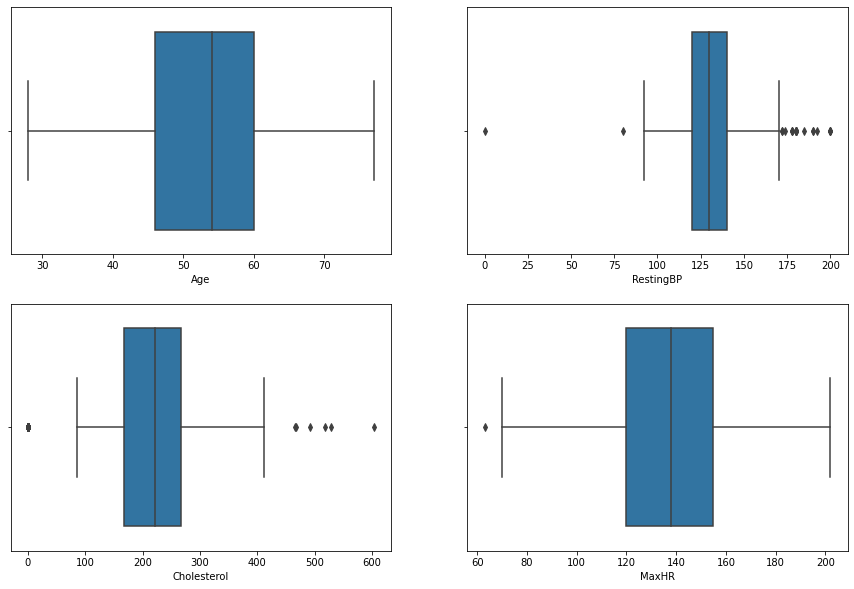

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(ax = axes[0,0], data=heart_select, x='Age')
sns.boxplot(ax = axes[0,1], data=heart_select, x='RestingBP')
sns.boxplot(ax = axes[1,0], data=heart_select, x='Cholesterol')
sns.boxplot(ax = axes[1,1], data=heart_select, x='MaxHR')

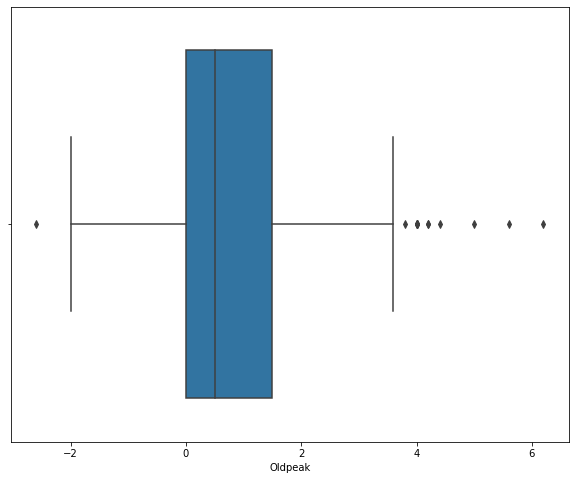

In [33]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=heart_select, x='Oldpeak')
plt.show()

note : 
1. terdapat outlier pada RestingBP, Cholesterol, MaxHR, Oldpeak

In [34]:
# pipeline numric train

numeric_pip_train = Pipeline([
    ('winsori', Winsorizer(capping_method='iqr', tail='both')),
    ('Scaler' , MinMaxScaler())
])

In [35]:
heart_prepare = numeric_pip_train.fit_transform(heart_select[num])

### Handling label

In [36]:
y_heart.shape

(734, 1)

In [37]:
y_heart.value_counts()

HeartDisease
1               405
0               329
dtype: int64

In [38]:
label = pd.DataFrame(y_heart.value_counts()).reset_index()
label['percent'] = (label[0]/y_heart.shape[0])*100
label.rename(columns={0:'count'}, inplace=True)

In [39]:
label

,HeartDisease,count,percent
0,1,405,55.177112
1,0,329,44.822888


In [40]:
fig = px.bar(label, x = "HeartDisease", y ='count',
             hover_data=['percent'])
fig.show()

### Pipeline

In [41]:
num

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [42]:
categoric

['Sex',
 'ChestPainType',
 'FastingBS',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope']

In [43]:
#piplen categori

pipeline_categori = Pipeline([
    ('drop', selectionFiture()),
    ('oneHot', OneHotEncoder())
])

#tranformer
tranformer = ColumnTransformer([
    ('cay', pipeline_categori, categoric),
    ('num', MinMaxScaler(), num)
])

In [44]:
heart_prepared = tranformer.fit_transform(heart)

In [45]:
heart_prepared.shape

(734, 18)

# Modeling

untuk kasus ini berfokus untuk menurunkan FP karena pada kasus ini saya tidak mau orang yang terkena sakit jantung tetapi dideteksi tidak sakit sehingga saya melihat Presision score

In [46]:
some_data = strat_test_sets[:10].copy()
some_label = some_data['HeartDisease'].copy()
some_data = some_data.drop('HeartDisease', axis=1)

In [47]:
some_label

893    1
642    0
715    0
705    0
699    0
295    1
684    1
446    1
866    0
316    1
Name: HeartDisease, dtype: int64

In [48]:
some_prepared = tranformer.transform(some_data)

In [49]:
some_prepared.shape

(10, 18)

In [50]:
test = strat_test_sets.copy()
test_label = test['HeartDisease'].copy()
test = test.drop('HeartDisease', axis=1)


test_prepared = tranformer.transform(test)

### Linear Model

#### Linear Regression

In [51]:

logic = LogisticRegression()
logic.fit(heart_prepared, y_heart)

logic_pred = logic.predict(heart_prepared)

In [52]:
print(f'accuracy : {accuracy_score(y_heart, logic_pred)}\n')
print(classification_report(y_heart, logic_pred))

accuracy : 0.8773841961852861

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       329
           1       0.88      0.91      0.89       405

    accuracy                           0.88       734
   macro avg       0.88      0.87      0.88       734
weighted avg       0.88      0.88      0.88       734



In [53]:
cros_val_logic = cross_val_score(logic, heart_prepared, y_heart, cv=5, scoring='precision')

print(f"precision:\nmaen : {cros_val_logic.mean()}\nstd : {cros_val_logic.std()}")

precision:
maen : 0.8781310229518164
std : 0.01953745323496193


In [54]:
cros_val_logic = cross_val_score(logic, heart_prepared, y_heart, cv=5, scoring='accuracy')

print(f"accuracy :\nmaen : {cros_val_logic.mean()}\nstd : {cros_val_logic.std()}")

accuracy :
maen : 0.8760320566582799
std : 0.02246575218771758


In [55]:
logic_pred_some = logic.predict(some_prepared)
print(accuracy_score(some_label, logic_pred_some))
print(classification_report(some_label, logic_pred_some))

0.7
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



#### RidgeClassifier

node : dapat dilihat meskipun semua model mengalami overvitting tetapi yang memiliki selisih paling kecil yaitu Logistic regression

### SVM

In [56]:
svc = SVC()
svc.fit(heart_prepared, y_heart)
svc_pred = svc.predict(heart_prepared)

In [57]:
print(f'accuracy : {accuracy_score(y_heart, svc_pred)}')
print(classification_report(y_heart, svc_pred))

accuracy : 0.8896457765667575
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       329
           1       0.88      0.93      0.90       405

    accuracy                           0.89       734
   macro avg       0.89      0.89      0.89       734
weighted avg       0.89      0.89      0.89       734



In [58]:
cros_val_svc = cross_val_score(svc, heart_prepared, y_heart, cv=5, scoring='precision')

print(f"maen : {cros_val_svc.mean()}\nstd : {cros_val_svc.std()}")

maen : 0.8595707070962572
std : 0.030592341316677395


In [59]:
cros_val_svc = cross_val_score(svc, heart_prepared, y_heart, cv=5, scoring='accuracy')

print(f"maen : {cros_val_svc.mean()}\nstd : {cros_val_svc.std()}")

maen : 0.8665082471344702
std : 0.01569214415043649


In [60]:
svc_pred_some = svc.predict(some_prepared)
print(f'accuracy : {accuracy_score(some_label, svc_pred_some)}')
print(classification_report(some_label, svc_pred_some))

accuracy : 0.7
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



node : 
1. mengalami overfiting
2. accuracy keluar dari jangkauan cross val
3. precision keluar dari jangkauan cross val

### ensemble

#### Random Forest

In [61]:
rf = RandomForestClassifier()
rf.fit(heart_prepared, y_heart)
rf_pred = rf.predict(heart_prepared)

In [62]:
print(f'accurcy : {accuracy_score(y_heart, rf_pred)}')
print(classification_report(y_heart, rf_pred))

accurcy : 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       329
           1       1.00      1.00      1.00       405

    accuracy                           1.00       734
   macro avg       1.00      1.00      1.00       734
weighted avg       1.00      1.00      1.00       734



In [63]:
cros_val_rf = cross_val_score(rf, heart_prepared, y_heart, cv=5, scoring='precision')

print(f"maen : {cros_val_rf.mean()}\nstd : {cros_val_rf.std()}")

maen : 0.8779706301053949
std : 0.00735072699991932


In [64]:
cros_val_rf = cross_val_score(rf, heart_prepared, y_heart, cv=5, scoring='accuracy')

print(f"maen : {cros_val_rf.mean()}\nstd : {cros_val_rf.std()}")

maen : 0.8678501537601342
std : 0.022990669047317742


In [65]:
rf_pred_some = rf.predict(some_prepared)
print(f'accuracy : {accuracy_score(some_label, rf_pred_some)}\n')
print(classification_report(some_label, rf_pred_some))

accuracy : 0.7

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



#### AdaBost

In [66]:
ada = AdaBoostClassifier()
ada.fit(heart_prepared, y_heart)
ada_pred = ada.predict(heart_prepared)

In [67]:
print(f'accuracy : {accuracy_score(y_heart, ada_pred)}\n')
print(classification_report(y_heart, ada_pred))

accuracy : 0.8991825613079019

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       329
           1       0.91      0.91      0.91       405

    accuracy                           0.90       734
   macro avg       0.90      0.90      0.90       734
weighted avg       0.90      0.90      0.90       734



In [68]:
cros_val_ada = cross_val_score(ada, heart_prepared, y_heart, cv=5, scoring='precision')

print(f"maen : {cros_val_ada.mean()}\nstd : {cros_val_ada.std()}")

maen : 0.8760980951482036
std : 0.026502460246547177


In [69]:
cros_val_ada = cross_val_score(ada, heart_prepared, y_heart, cv=5, scoring='accuracy')

print(f"maen : {cros_val_ada.mean()}\nstd : {cros_val_ada.std()}")

maen : 0.8555866182089273
std : 0.015737391118237524


In [70]:
some_pred_ada = ada.predict(some_prepared)
print(f'accuracy : {accuracy_score(some_label, some_pred_ada)}\n')
print(classification_report(some_label, some_pred_ada))

accuracy : 0.6

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10



### Tree

In [71]:
tree = DecisionTreeClassifier()
tree.fit(heart_prepared, y_heart)
tree_pred = tree.predict(heart_prepared)

In [72]:
print(f'accuracy : {accuracy_score(y_heart, tree_pred)}\n')
print(classification_report(y_heart, tree_pred))

accuracy : 1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       329
           1       1.00      1.00      1.00       405

    accuracy                           1.00       734
   macro avg       1.00      1.00      1.00       734
weighted avg       1.00      1.00      1.00       734



In [73]:
#precision
cros_val_tree = cross_val_score(tree, heart_prepared, y_heart, cv=5, scoring='precision')

print(f"maen : {cros_val_tree.mean()}\nstd : {cros_val_tree.std()}")

maen : 0.832759683458413
std : 0.018612529497251184


In [74]:
# accuracy
cros_val_tree = cross_val_score(tree, heart_prepared, y_heart, cv=5, scoring='accuracy')

print(f"maen : {cros_val_tree.mean()}\nstd : {cros_val_tree.std()}")

maen : 0.8119466964868138
std : 0.024933100056864825


In [75]:
some_pred_tree = tree.predict(some_prepared)
print(f'accuracy : {accuracy_score(some_label, some_pred_tree)}\n')
print(classification_report(some_label, some_pred_tree))

accuracy : 0.7

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



## Hyperparameter tuning

### Linear

#### logic

##### Random

In [76]:
#Random Grid
penalty = ['l2', 'l1', 'elasticnet']
c = [10, 20, 30]
solver = ['newton-cg', 'lbfgs', 'liblinear']

random_grid_logic = {'penalty' : penalty,
                     'C' : c,
                     'solver' : solver}
random_grid_logic

{'penalty': ['l2', 'l1', 'elasticnet'],
 'C': [10, 20, 30],
 'solver': ['newton-cg', 'lbfgs', 'liblinear']}

In [77]:
logic_R = LogisticRegression()
logic_randomcv = RandomizedSearchCV(estimator= logic_R, param_distributions = random_grid_logic,n_jobs=-1,  cv=5, random_state=1, scoring = 'precision')
logic_randomcv.fit(heart_prepared, y_heart)

/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [10, 20, 30],
                                        'penalty': ['l2', 'l1', 'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   random_state=1, scoring='precision')

In [78]:
logic_tuningR_best = logic_randomcv.best_estimator_
print(logic_randomcv.best_params_, logic_randomcv.best_score_)

{'solver': 'liblinear', 'penalty': 'l1', 'C': 20} 0.8805090311986865


In [79]:
logic_bestR_pred = logic_tuningR_best.predict(heart_prepared)
print(classification_report(y_heart, logic_bestR_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       329
           1       0.88      0.91      0.90       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [80]:
logic_random = pd.concat([pd.DataFrame(logic_randomcv.cv_results_["params"]),
                          pd.DataFrame(logic_randomcv.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)
logic_random

,solver,penalty,C,precision
0,liblinear,elasticnet,20,NaN
1,liblinear,l1,20,0.880509
2,newton-cg,l2,30,0.880509
3,newton-cg,l1,10,NaN
4,liblinear,l1,30,0.880509
5,lbfgs,l2,20,0.880509
6,liblinear,l2,30,0.880509
7,newton-cg,l1,30,NaN
8,lbfgs,l1,10,NaN
9,liblinear,l2,10,0.880509


In [81]:
logic_randomcv.cv_results_

{'mean_fit_time': array([0.00090079, 0.0158566 , 0.02222714, 0.00065098, 0.03079052,
        0.03123231, 0.00500031, 0.00070543, 0.00071421, 0.0071476 ]),
 'std_fit_time': array([6.94050202e-05, 4.21113418e-03, 2.57390790e-03, 9.83922713e-05,
        1.80901526e-02, 5.69645195e-03, 1.52627104e-03, 1.59412018e-05,
        3.13832034e-05, 7.54770146e-03]),
 'mean_score_time': array([0.        , 0.00203705, 0.00185022, 0.        , 0.00228829,
        0.00185041, 0.00190835, 0.        , 0.        , 0.00203786]),
 'std_score_time': array([0.00000000e+00, 1.88198088e-04, 1.02637534e-04, 0.00000000e+00,
        1.06542161e-03, 7.39253551e-05, 5.83566476e-05, 0.00000000e+00,
        0.00000000e+00, 6.56120472e-04]),
 'param_solver': masked_array(data=['liblinear', 'liblinear', 'newton-cg', 'newton-cg',
                    'liblinear', 'lbfgs', 'liblinear', 'newton-cg',
                    'lbfgs', 'liblinear'],
              mask=[False, False, False, False, False, False, False, False,
       

##### GridSRC

In [82]:
#GridSearchCV
param_grid_logic = {
    'penalty' : [logic_randomcv.best_params_['penalty']],
    'C' : [logic_randomcv.best_params_['C'],
        logic_randomcv.best_params_['C']+3,
           logic_randomcv.best_params_['C']-3,
           logic_randomcv.best_params_['C']-2,
           logic_randomcv.best_params_['C']-1,
           logic_randomcv.best_params_['C']+2,
           logic_randomcv.best_params_['C']+1,
           logic_randomcv.best_params_['C']+5,
           logic_randomcv.best_params_['C']+10],
    'solver' : [logic_randomcv.best_params_['solver']]
}
print(param_grid_logic)

{'penalty': ['l1'], 'C': [20, 23, 17, 18, 19, 22, 21, 25, 30], 'solver': ['liblinear']}


In [83]:
logic_G = LogisticRegression()
logic_Grid = GridSearchCV(estimator=logic_G, param_grid=param_grid_logic,
                                 n_jobs = -1,cv=5, scoring='precision')
logic_Grid.fit(heart_prepared, y_heart)

/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [20, 23, 17, 18, 19, 22, 21, 25, 30],
                         'penalty': ['l1'], 'solver': ['liblinear']},
             scoring='precision')

In [84]:
logic_tuningG_best = logic_Grid.best_estimator_
print(logic_Grid.best_params_)

{'C': 20, 'penalty': 'l1', 'solver': 'liblinear'}


In [85]:
logic_bestG_pred = logic_tuningG_best.predict(heart_prepared)
print(classification_report(y_heart, logic_bestG_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       329
           1       0.88      0.91      0.90       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [86]:

logic_grid_df = pd.concat([pd.DataFrame(logic_Grid.cv_results_["params"]),
                          pd.DataFrame(logic_Grid.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)
logic_grid_df

,C,penalty,solver,precision
0,20,l1,liblinear,0.880509
1,23,l1,liblinear,0.880509
2,17,l1,liblinear,0.880509
3,18,l1,liblinear,0.880509
4,19,l1,liblinear,0.880509
5,22,l1,liblinear,0.880509
6,21,l1,liblinear,0.880509
7,25,l1,liblinear,0.880509
8,30,l1,liblinear,0.880509


##### Model inferns

In [87]:
logic_bestR_pred = logic_tuningR_best.predict(heart_prepared)
print(f'train R : \n{classification_report(y_heart, logic_bestR_pred)}')

train R : 
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       329
           1       0.88      0.91      0.90       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [88]:
test_bestR_pred = logic_tuningR_best.predict(test_prepared)
print(f'test R : \n{classification_report(test_label, test_bestR_pred)}')

test R : 
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        81
           1       0.83      0.88      0.86       103

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



In [89]:
logic_bestG_pred = logic_tuningG_best.predict(heart_prepared)
print(f'train G : \n{classification_report(y_heart, logic_bestG_pred)}')

train G : 
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       329
           1       0.88      0.91      0.90       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [90]:
train_bestG_pred = logic_tuningG_best.predict(test_prepared)
print(f'train G : \n{classification_report(test_label, train_bestG_pred)}')

train G : 
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        81
           1       0.83      0.88      0.86       103

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



#### RidgeClassifier

##### Random

In [91]:
alpha = list(a for a in np.linspace(1.0, 3.0, 5))
max_iter = list(i for i in range(1,6))
solver = ['auto', 'svd', 'cholesky', 'isqr', 'sparse_cg', 'sag', 'lbfgs']

param = {
    'alpha' : alpha,
    'max_iter' : max_iter,
    'solver' : solver
}

print(param)

{'alpha': [1.0, 1.5, 2.0, 2.5, 3.0], 'max_iter': [1, 2, 3, 4, 5], 'solver': ['auto', 'svd', 'cholesky', 'isqr', 'sparse_cg', 'sag', 'lbfgs']}


In [92]:
ridge_R = RidgeClassifier()
ridge_random_grid = RandomizedSearchCV(ridge_R,param , scoring='precision', n_jobs=-1, cv=5)

In [93]:
ridge_random_grid.fit(heart_prepared, y_heart)

/home/arsy/.local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

RandomizedSearchCV(cv=5, estimator=RidgeClassifier(), n_jobs=-1,
                   param_distributions={'alpha': [1.0, 1.5, 2.0, 2.5, 3.0],
                                        'max_iter': [1, 2, 3, 4, 5],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'isqr', 'sparse_cg', 'sag',
                                                   'lbfgs']},
                   scoring='precision')

In [94]:
ridge_tuningR_best = ridge_random_grid.best_estimator_
print(ridge_random_grid.best_params_)

{'solver': 'auto', 'max_iter': 2, 'alpha': 3.0}


In [95]:
ridge_bestR_pred = ridge_tuningR_best.predict(heart_prepared)
print(classification_report(y_heart, ridge_bestR_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       329
           1       0.88      0.90      0.89       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [96]:

ridge_random_df = pd.concat([pd.DataFrame(ridge_random_grid.cv_results_["params"]),
                          pd.DataFrame(ridge_random_grid.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)
ridge_random_df

,solver,max_iter,alpha,precision
0,lbfgs,3,2.5,NaN
1,sag,4,1.5,0.870830
2,cholesky,1,1.5,0.883097
3,lbfgs,2,1.5,NaN
4,svd,1,1.0,0.883097
5,sag,5,1.5,0.867376
6,svd,3,1.5,0.883097
7,cholesky,1,1.0,0.883097
8,auto,2,3.0,0.883399
9,cholesky,2,3.0,0.883399


##### GridSRC

In [97]:
param_grid = {
    'solver' : [ridge_random_grid.best_params_['solver']],
    'max_iter' : [ridge_random_grid.best_params_['max_iter'],
                  ridge_random_grid.best_params_['max_iter']-1,
                  ridge_random_grid.best_params_['max_iter']+5,
                  ridge_random_grid.best_params_['max_iter']+6],
    'alpha' : [ridge_random_grid.best_params_['alpha'],
               ridge_random_grid.best_params_['alpha'] - 2.0,
               ridge_random_grid.best_params_['alpha'] - 1.0,
               ridge_random_grid.best_params_['alpha'] + 1.0,
               ridge_random_grid.best_params_['alpha'] + 2.0,
               ridge_random_grid.best_params_['alpha'] + 3.0,]
}
param_grid

{'solver': ['auto'],
 'max_iter': [2, 1, 7, 8],
 'alpha': [3.0, 1.0, 2.0, 4.0, 5.0, 6.0]}

In [98]:
ridge_G = RidgeClassifier()
ridge_grid = GridSearchCV(estimator=ridge_G, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
ridge_grid.fit(heart_prepared, y_heart)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/arsy/.local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

GridSearchCV(cv=5, estimator=RidgeClassifier(), n_jobs=-1,
             param_grid={'alpha': [3.0, 1.0, 2.0, 4.0, 5.0, 6.0],
                         'max_iter': [2, 1, 7, 8], 'solver': ['auto']},
             verbose=1)

In [99]:
ridge_tuningG_best = ridge_grid.best_estimator_
print(ridge_grid.best_params_)

{'alpha': 3.0, 'max_iter': 2, 'solver': 'auto'}


In [100]:
ridge_bestG_pred = ridge_tuningG_best.predict(heart_prepared)
print(classification_report(y_heart, ridge_bestG_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       329
           1       0.88      0.90      0.89       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [101]:

ridge_grid_df = pd.concat([pd.DataFrame(ridge_grid.cv_results_["params"]),
                          pd.DataFrame(ridge_grid.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)
ridge_grid_df

,alpha,max_iter,solver,precision
0,3.0,2,auto,0.877402
1,3.0,1,auto,0.877402
2,3.0,7,auto,0.877402
3,3.0,8,auto,0.877402
4,1.0,2,auto,0.876041
5,1.0,1,auto,0.876041
6,1.0,7,auto,0.876041
7,1.0,8,auto,0.876041
8,2.0,2,auto,0.877402
9,2.0,1,auto,0.877402


##### models infers

In [102]:
testR_ridge = ridge_tuningR_best.predict(test_prepared)
testG_ridge = ridge_tuningG_best.predict(test_prepared)

In [103]:
ridge_bestR_pred = ridge_tuningR_best.predict(heart_prepared)
print(f'train R : \n{classification_report(y_heart, ridge_bestR_pred)}')

train R : 
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       329
           1       0.88      0.90      0.89       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [104]:
print(f'test R : \n')
print(classification_report(test_label, testR_ridge))

test R : 

              precision    recall  f1-score   support

           0       0.83      0.77      0.79        81
           1       0.83      0.87      0.85       103

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184



In [105]:
ridge_bestG_pred = ridge_tuningG_best.predict(heart_prepared)
print(f'train G : \n{classification_report(y_heart, ridge_bestG_pred)}')

train G : 
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       329
           1       0.88      0.90      0.89       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [106]:
print(f'test G : \n{classification_report(test_label, testG_ridge)}')

test G : 
              precision    recall  f1-score   support

           0       0.83      0.77      0.79        81
           1       0.83      0.87      0.85       103

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184



Random

### SVM

##### Random

In [107]:
svm_R = SVC()
params = {
   'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
   'degree' : [int(x) for x in np.linspace(1,6, 2)],
   'gamma' : ['scale', 'auto'],
   'coef0' : [float(x) for x in np.linspace(0.0, 1, 3)]
}

print(params)


{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [1, 6], 'gamma': ['scale', 'auto'], 'coef0': [0.0, 0.5, 1.0]}


In [108]:
SVM_Random_grid = RandomizedSearchCV(svm_R, params, scoring='accuracy', n_jobs=-1,cv = 5)
SVM_Random_grid.fit(heart_prepared, y_heart)

/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'coef0': [0.0, 0.5, 1.0],
                                        'degree': [1, 6],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring='accuracy')

In [109]:
svm_tuningR_best = SVM_Random_grid.best_estimator_
print(SVM_Random_grid.best_params_)

{'kernel': 'linear', 'gamma': 'scale', 'degree': 6, 'coef0': 0.0}


In [110]:
svm_bestR_pred = svm_tuningR_best.predict(heart_prepared)
print(classification_report(y_heart, svm_bestR_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       329
           1       0.88      0.91      0.90       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [111]:

svm_random_df = pd.concat([pd.DataFrame(SVM_Random_grid.cv_results_["params"]),
                          pd.DataFrame(SVM_Random_grid.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)
svm_random_df

,kernel,gamma,degree,coef0,precision
0,poly,scale,6,0.0,0.854245
1,linear,scale,6,0.0,0.874662
2,rbf,auto,1,1.0,0.858336
3,rbf,scale,1,1.0,0.866508
4,poly,scale,6,1.0,0.836502
5,linear,scale,1,1.0,0.874662
6,sigmoid,auto,6,0.0,0.854263
7,linear,scale,1,0.0,0.874662
8,sigmoid,auto,1,0.5,0.855633
9,sigmoid,scale,1,1.0,0.833818


In [112]:
svm_random_df['precision'].max()

0.8746621936445813

##### GridSRC

In [113]:
# GridSearch 
params_grid = {
    'kernel' : [SVM_Random_grid.best_params_['kernel']],
    'gamma' : [SVM_Random_grid.best_params_['gamma']],
    'degree' : [SVM_Random_grid.best_params_['degree'],
                SVM_Random_grid.best_params_['degree']-1,
                SVM_Random_grid.best_params_['degree']+1,
                SVM_Random_grid.best_params_['degree']-2,
                SVM_Random_grid.best_params_['degree']+2],
    
    'coef0' : [SVM_Random_grid.best_params_['coef0'],
               SVM_Random_grid.best_params_['coef0'] - 0.25,
               SVM_Random_grid.best_params_['coef0'] + 0.25,
               SVM_Random_grid.best_params_['coef0'] + 0.1]
}
SVM_G = SVC()
params_grid


{'kernel': ['linear'],
 'gamma': ['scale'],
 'degree': [6, 5, 7, 4, 8],
 'coef0': [0.0, -0.25, 0.25, 0.1]}

In [114]:
svm_grid= GridSearchCV(estimator=SVM_G, param_grid=params_grid, cv=5,n_jobs=-1, verbose=1)
svm_grid.fit(heart_prepared, y_heart)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'coef0': [0.0, -0.25, 0.25, 0.1],
                         'degree': [6, 5, 7, 4, 8], 'gamma': ['scale'],
                         'kernel': ['linear']},
             verbose=1)

In [115]:
svm_tuningG_best = svm_grid.best_estimator_
print(svm_grid.best_params_)

{'coef0': 0.0, 'degree': 6, 'gamma': 'scale', 'kernel': 'linear'}


In [116]:
svm_bestG_pred = svm_tuningG_best.predict(heart_prepared)
print(classification_report(y_heart, svm_bestG_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       329
           1       0.88      0.91      0.90       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [117]:

svm_grid_df = pd.concat([pd.DataFrame(svm_grid.cv_results_["params"]),
                          pd.DataFrame(svm_grid.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)
svm_grid_df

,coef0,degree,gamma,kernel,precision
0,0.00,6,scale,linear,0.874662
1,0.00,5,scale,linear,0.874662
2,0.00,7,scale,linear,0.874662
3,0.00,4,scale,linear,0.874662
4,0.00,8,scale,linear,0.874662
5,-0.25,6,scale,linear,0.874662
6,-0.25,5,scale,linear,0.874662
7,-0.25,7,scale,linear,0.874662
8,-0.25,4,scale,linear,0.874662
9,-0.25,8,scale,linear,0.874662


In [118]:
svm_grid_df['precision'].max() == 0.8774019196719784

False

##### model infers

In [119]:
svm_bestR_pred = svm_tuningR_best.predict(heart_prepared)
print(f'train R : \n{classification_report(y_heart, svm_bestR_pred)}')

train R : 
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       329
           1       0.88      0.91      0.90       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [120]:
test_bestR_pred = svm_tuningR_best.predict(test_prepared)
print(f'test R : \n{classification_report(test_label, test_bestR_pred)}')

test R : 
              precision    recall  f1-score   support

           0       0.82      0.75      0.79        81
           1       0.82      0.87      0.85       103

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.82      0.82      0.82       184



In [121]:
svm_bestG_pred = svm_tuningG_best.predict(heart_prepared)
print(f'Train G : \n{classification_report(y_heart, svm_bestG_pred)}')

Train G : 
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       329
           1       0.88      0.91      0.90       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [122]:
test_bestG_pred = svm_tuningG_best.predict(test_prepared)
print(f'Train G : \n{classification_report(test_label, test_bestG_pred)}')

Train G : 
              precision    recall  f1-score   support

           0       0.82      0.75      0.79        81
           1       0.82      0.87      0.85       103

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.82      0.82      0.82       184



### ensemble

#### Random Forest

##### Random

In [123]:
rf_R = RandomForestClassifier(random_state=1)
params = {
    'n_estimators' : [3, 5, 7, 9],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'max_depth' : [int(x) for x in np.linspace(1, 10, 5)],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [4,6,8],
    'criterion' : ['entropy' , 'gini']
}
params

{'n_estimators': [3, 5, 7, 9],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [1, 3, 5, 7, 10],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [4, 6, 8],
 'criterion': ['entropy', 'gini']}

In [124]:
rf_random_gread = RandomizedSearchCV(estimator=rf, param_distributions=params, n_jobs=-1, cv=5)
rf_random_gread.fit(heart_prepared, y_heart)

/home/arsy/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [1, 3, 5, 7, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [3, 5, 7, 9]})

In [125]:
rf_tuningR_best = rf_random_gread.best_estimator_
print(rf_random_gread.best_params_)

{'n_estimators': 9, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy'}


In [126]:
rf_bestR_pred = rf_tuningR_best.predict(heart_prepared)
print(classification_report(y_heart, rf_bestR_pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       329
           1       0.89      0.92      0.91       405

    accuracy                           0.90       734
   macro avg       0.90      0.89      0.89       734
weighted avg       0.90      0.90      0.90       734



In [127]:
rf_random_df = pd.concat([pd.DataFrame(rf_random_gread.cv_results_["params"]),
                          pd.DataFrame(rf_random_gread.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)
rf_random_df

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,criterion,precision
0,7,10,6,log2,3,entropy,0.861038
1,5,5,6,auto,1,entropy,0.837890
2,9,10,6,sqrt,1,gini,0.846044
3,3,2,6,log2,1,gini,0.803765
4,5,5,6,log2,3,entropy,0.865120
5,9,10,8,log2,7,entropy,0.874653
6,5,2,6,log2,1,entropy,0.829727
7,3,10,8,sqrt,3,entropy,0.866480
8,7,2,6,auto,5,entropy,0.869220
9,9,5,6,sqrt,5,entropy,0.874662


In [128]:
rf_random_df['precision'].max()

0.8746621936445811

##### Grid

In [129]:
param_grid = {
    'n_estimators' : [rf_random_gread.best_params_['n_estimators'],
                    rf_random_gread.best_params_['n_estimators']-2,
                     rf_random_gread.best_params_['n_estimators']+2,
                     rf_random_gread.best_params_['n_estimators']+3,
                     rf_random_gread.best_params_['n_estimators']+4],
    
    'min_samples_split' : [rf_random_gread.best_params_['min_samples_split'],
                           rf_random_gread.best_params_['min_samples_split']-1,
                           rf_random_gread.best_params_['min_samples_split']+1],
    
    'max_features' : [rf_random_gread.best_params_['max_features']],
    
    'min_samples_leaf' : [rf_random_gread.best_params_['min_samples_leaf'],
                          rf_random_gread.best_params_['min_samples_leaf']-1,
                          rf_random_gread.best_params_['min_samples_leaf']+1,
                          rf_random_gread.best_params_['min_samples_leaf']+2],
    
    'max_depth' : [rf_random_gread.best_params_['max_depth'],
                rf_random_gread.best_params_['max_depth']+10,
                rf_random_gread.best_params_['max_depth']+15],
    
    'criterion' : [rf_random_gread.best_params_['criterion']]
}
param_grid


{'n_estimators': [9, 7, 11, 12, 13],
 'min_samples_split': [5, 4, 6],
 'max_features': ['sqrt'],
 'min_samples_leaf': [6, 5, 7, 8],
 'max_depth': [5, 15, 20],
 'criterion': ['entropy']}

In [130]:
rf_G = RandomForestClassifier(random_state=7)
rf_grid = GridSearchCV(estimator=rf_G, param_grid = param_grid, n_jobs = -1, cv=5)
rf_grid.fit(heart_prepared, y_heart)

/home/arsy/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=7), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [5, 15, 20],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [6, 5, 7, 8],
                         'min_samples_split': [5, 4, 6],
                         'n_estimators': [9, 7, 11, 12, 13]})

In [131]:
rf_tuningG_best = rf_grid.best_estimator_
print(rf_grid.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 9}


In [132]:
rf_bestG_pred = rf_tuningG_best.predict(heart_prepared)
print(classification_report(y_heart, rf_bestG_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       329
           1       0.89      0.94      0.91       405

    accuracy                           0.90       734
   macro avg       0.90      0.89      0.90       734
weighted avg       0.90      0.90      0.90       734



In [133]:
rf_grid_df = pd.concat([pd.DataFrame(rf_grid.cv_results_["params"]),
                          pd.DataFrame(rf_grid.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)
rf_grid_df

,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,precision
0,entropy,5,sqrt,6,5,9,0.878753
1,entropy,5,sqrt,6,5,7,0.877393
2,entropy,5,sqrt,6,5,11,0.876041
3,entropy,5,sqrt,6,5,12,0.877383
4,entropy,5,sqrt,6,5,13,0.870581
...,...,...,...,...,...,...,...
175,entropy,20,sqrt,8,6,9,0.871922
176,entropy,20,sqrt,8,6,7,0.877402
177,entropy,20,sqrt,8,6,11,0.878735
178,entropy,20,sqrt,8,6,12,0.870562


In [134]:
rf_grid_df['precision'].max()

0.8828347777467151

##### model infers

In [135]:
rf_bestR_pred = rf_tuningR_best.predict(heart_prepared)
print(f'Train R : \n{classification_report(y_heart, rf_bestR_pred)}')

Train R : 
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       329
           1       0.89      0.92      0.91       405

    accuracy                           0.90       734
   macro avg       0.90      0.89      0.89       734
weighted avg       0.90      0.90      0.90       734



In [136]:
test_bestR_pred = rf_tuningR_best.predict(test_prepared)
print(f'Test R : \n{classification_report(test_label, test_bestR_pred)}')

Test R : 
              precision    recall  f1-score   support

           0       0.87      0.74      0.80        81
           1       0.82      0.91      0.86       103

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.83       184



In [137]:
rf_bestG_pred = rf_tuningG_best.predict(heart_prepared)
print(f'Train G : \n{classification_report(y_heart, rf_bestG_pred)}')

Train G : 
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       329
           1       0.89      0.94      0.91       405

    accuracy                           0.90       734
   macro avg       0.90      0.89      0.90       734
weighted avg       0.90      0.90      0.90       734



In [138]:
test_bestG_pred = rf_tuningG_best.predict(test_prepared)
print(f'Test G : \n{classification_report(test_label, test_bestG_pred)}')

Test G : 
              precision    recall  f1-score   support

           0       0.87      0.75      0.81        81
           1       0.82      0.91      0.87       103

    accuracy                           0.84       184
   macro avg       0.85      0.83      0.84       184
weighted avg       0.85      0.84      0.84       184



note : grid

#### Adaboos

##### Random

In [140]:
param = {
    'n_estimators' : [i for i in range (20, 70)],
    'learning_rate' : [i for i in np.linspace(1.0, 6.0, 12)],
    'algorithm' : ['SAMMER.R', 'SAMME']
}

ada_R = AdaBoostClassifier()
ada_random_grid = RandomizedSearchCV(ada_R, param, scoring='precision', n_jobs=-1, cv=5, verbose=1)
ada_random_grid.fit(heart_prepared, y_heart)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:655: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/home/arsy/.local/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:655: RuntimeWarning: overflow encountered in exp
  sample_weight = np.exp(
/home/arsy/.local/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:486: UserWarning: Sample weights have reached infinite values, at

RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
                   param_distributions={'algorithm': ['SAMMER.R', 'SAMME'],
                                        'learning_rate': [1.0,
                                                          1.4545454545454546,
                                                          1.9090909090909092,
                                                          2.3636363636363633,
                                                          2.8181818181818183,
                                                          3.2727272727272725,
                                                          3.727272727272727,
                                                          4.181818181818182,
                                                          4.636363636363637,
                                                          5.090909090909091,
                                                          5.545454545454545,
                  

In [141]:
ada_tuningR_best = ada_random_grid.best_estimator_
print(ada_random_grid.best_params_)

{'n_estimators': 33, 'learning_rate': 5.545454545454545, 'algorithm': 'SAMME'}


In [142]:
ada_bestR_pred = ada_tuningR_best.predict(heart_prepared)
print(classification_report(y_heart, ada_bestR_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       329
           1       0.85      0.85      0.85       405

    accuracy                           0.83       734
   macro avg       0.83      0.83      0.83       734
weighted avg       0.83      0.83      0.83       734



In [143]:

ada_random_df = pd.concat([pd.DataFrame(ada_random_grid.cv_results_["params"]),
                          pd.DataFrame(ada_random_grid.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)
ada_random_df

,n_estimators,learning_rate,algorithm,precision
0,33,5.545455,SAMME,0.846577
1,40,2.363636,SAMME,0.177937
2,24,3.272727,SAMME,0.177937
3,34,1.000000,SAMMER.R,NaN
4,66,5.545455,SAMMER.R,NaN
5,55,5.545455,SAMME,0.846577
6,46,5.545455,SAMME,0.846577
7,36,1.000000,SAMMER.R,NaN
8,26,3.272727,SAMMER.R,NaN
9,23,6.000000,SAMME,0.177937


##### Grid

In [144]:
ada_random_grid.best_params_

{'n_estimators': 33, 'learning_rate': 5.545454545454545, 'algorithm': 'SAMME'}

In [145]:
param_grid = {
    'n_estimators' : [ada_random_grid.best_params_['n_estimators'],
                     ada_random_grid.best_params_['n_estimators']+3,
                     ada_random_grid.best_params_['n_estimators']+2,
                     ada_random_grid.best_params_['n_estimators']+1,
                     ada_random_grid.best_params_['n_estimators']-3,
                     ada_random_grid.best_params_['n_estimators']-2,
                     ada_random_grid.best_params_['n_estimators']-1,],
    
    'learning_rate' : [ada_random_grid.best_params_['learning_rate'],
                       ada_random_grid.best_params_['learning_rate'] + 2.0,
                       ada_random_grid.best_params_['learning_rate'] + 3.0,
                       ada_random_grid.best_params_['learning_rate'] + 4.0,
                       ada_random_grid.best_params_['learning_rate'] + 1.0,
                       ada_random_grid.best_params_['learning_rate'] - 2.0,
                       ada_random_grid.best_params_['learning_rate'] - 3.0,
                       ada_random_grid.best_params_['learning_rate'] - 4.0,
                       ada_random_grid.best_params_['learning_rate'] - 1.0],
    'algorithm' : [ada_random_grid.best_params_['algorithm']]
}

ada_G = AdaBoostClassifier()
ada_grid = GridSearchCV(estimator=ada_G, scoring='precision', 
                        param_grid = param_grid, cv=5, n_jobs=-1, verbose=1)

ada_grid.fit(heart_prepared, y_heart)


Fitting 5 folds for each of 63 candidates, totalling 315 fits


/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/arsy/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME'],
                         'learning_rate': [5.545454545454545, 7.545454545454545,
                                           8.545454545454545, 9.545454545454545,
                                           6.545454545454545, 3.545454545454545,
                                           2.545454545454545, 1.545454545454545,
                                           4.545454545454545],
                         'n_estimators': [33, 36, 35, 34, 30, 31, 32]},
             scoring='precision', verbose=1)

In [146]:
ada_tuningG_best = ada_grid.best_estimator_
print(ada_grid.best_params_)

{'algorithm': 'SAMME', 'learning_rate': 1.545454545454545, 'n_estimators': 33}


In [147]:
ada_bestG_pred = ada_tuningG_best.predict(heart_prepared)
print(classification_report(y_heart, ada_bestG_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       329
           1       0.90      0.87      0.88       405

    accuracy                           0.87       734
   macro avg       0.87      0.87      0.87       734
weighted avg       0.87      0.87      0.87       734



In [148]:
ada_grid_df = pd.concat([pd.DataFrame(ada_grid.cv_results_["params"]),
                          pd.DataFrame(ada_grid.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)
ada_grid_df

,algorithm,learning_rate,n_estimators,precision
0,SAMME,5.545455,33,0.846577
1,SAMME,5.545455,36,0.846577
2,SAMME,5.545455,35,0.846577
3,SAMME,5.545455,34,0.846577
4,SAMME,5.545455,30,0.846577
...,...,...,...,...
58,SAMME,4.545455,35,0.846577
59,SAMME,4.545455,34,0.846577
60,SAMME,4.545455,30,0.846577
61,SAMME,4.545455,31,0.846577


In [ ]:
ada_random_df['precision'].max()

0.8832752029197322

In [ ]:
ada_grid_df['precision'].max()

0.8836752143224544

##### model infers

In [ ]:
ada_bestR_pred = ada_tuningR_best.predict(heart_prepared)
print(f'Train R : \n{classification_report(y_heart, ada_bestR_pred)}')

Train R : 
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       329
           1       0.89      0.89      0.89       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [ ]:
test_bestR_pred = ada_tuningR_best.predict(test_prepared)
print(f'Test R : \n{classification_report(test_label, test_bestR_pred)}')

Test R : 
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        81
           1       0.85      0.87      0.86       103

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



In [ ]:
ada_bestG_pred = ada_tuningG_best.predict(heart_prepared)
print(f'Train G : \n{classification_report(y_heart, ada_bestG_pred)}')

Train G : 
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       329
           1       0.89      0.89      0.89       405

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734



In [ ]:
test_bestG_pred = ada_tuningG_best.predict(test_prepared)
print(f'Test G : \n{classification_report(test_label, test_bestG_pred)}')

Test G : 
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        81
           1       0.85      0.87      0.86       103

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



note : dapat dilihat bagus Grid

### Tree

##### Random

In [ ]:
# Random Decision Tree
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 10))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 10)), 
}

dt_R = DecisionTreeClassifier(random_state = 2)

dt_random_grid = RandomizedSearchCV(dt_R, params, scoring='accuracy', n_jobs = -1, cv=5)
dt_random_grid.fit(heart_prepared, y_heart)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2),
                   n_jobs=-1,
                   param_distributions={'criterion': ('gini', 'entropy'),
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                      9],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4],
                                        'splitter': ('best', 'random')},
                   scoring='accuracy')

In [ ]:
dt_tuningR_best = dt_random_grid.best_estimator_
print(dt_random_grid.best_params_)

{'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 4, 'criterion': 'gini'}


In [ ]:
dt_bestR_pred = dt_tuningR_best.predict(heart_prepared)
print(classification_report(y_heart, dt_bestR_pred))

              precision    recall  f1-score   support

           0       0.91      0.83      0.86       329
           1       0.87      0.93      0.90       405

    accuracy                           0.88       734
   macro avg       0.89      0.88      0.88       734
weighted avg       0.89      0.88      0.88       734



In [ ]:
dt_random_df = pd.concat([pd.DataFrame(dt_random_grid.cv_results_["params"]),
                          pd.DataFrame(dt_random_grid.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)
dt_random_df

,splitter,min_samples_split,min_samples_leaf,max_depth,criterion,precision
0,best,4,7,5,entropy,0.837862
1,random,2,9,9,entropy,0.855615
2,best,4,7,9,gini,0.844656
3,random,3,7,2,entropy,0.833809
4,random,2,5,4,gini,0.859687
5,best,4,6,9,entropy,0.829634
6,best,4,7,4,gini,0.855577
7,best,2,5,8,gini,0.839241
8,random,2,3,1,gini,0.833809
9,best,3,5,8,entropy,0.833762


In [ ]:
dt_random_df['precision'].max()

0.8596868884540116

##### Grid

In [ ]:
#Gread Search
param_grid = {
    'splitter' : [dt_random_grid.best_params_['splitter']],
    'criterion' : [dt_random_grid.best_params_['criterion']],
    'max_depth' : [dt_random_grid.best_params_['max_depth']],
    'min_samples_leaf' : [dt_random_grid.best_params_['min_samples_leaf'],
                          dt_random_grid.best_params_['min_samples_leaf']-1,
                          dt_random_grid.best_params_['min_samples_leaf']+1,
                          dt_random_grid.best_params_['min_samples_leaf']+2],
    'min_samples_split' : [dt_random_grid.best_params_['min_samples_split']+10,
                          dt_random_grid.best_params_['min_samples_split']+15]
}
param_grid


{'splitter': ['random'],
 'criterion': ['gini'],
 'max_depth': [4],
 'min_samples_leaf': [5, 4, 6, 7],
 'min_samples_split': [12, 17]}

In [ ]:
dt_G = DecisionTreeClassifier(random_state=31)
dt_grid = GridSearchCV(estimator=dt_G, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

In [ ]:
dt_grid.fit(heart_prepared, y_heart)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=31), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [4],
                         'min_samples_leaf': [5, 4, 6, 7],
                         'min_samples_split': [12, 17],
                         'splitter': ['random']},
             verbose=1)

In [ ]:
dt_tuningG_best = dt_grid.best_estimator_
print(dt_grid.best_params_)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 6, 'min_samples_split': 17, 'splitter': 'random'}


In [ ]:
dt_bestG_pred = dt_tuningG_best.predict(heart_prepared)
print(classification_report(y_heart, dt_bestG_pred))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       329
           1       0.86      0.92      0.89       405

    accuracy                           0.87       734
   macro avg       0.88      0.87      0.87       734
weighted avg       0.88      0.87      0.87       734



In [ ]:
dt_grid_df = pd.concat([pd.DataFrame(dt_grid.cv_results_["params"]),
                          pd.DataFrame(dt_grid.cv_results_["mean_test_score"], 
                          columns=["precision"])],
                          axis=1)
dt_grid_df

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,precision
0,gini,4,5,12,random,0.852884
1,gini,4,5,17,random,0.855605
2,gini,4,4,12,random,0.846072
3,gini,4,4,17,random,0.848793
4,gini,4,6,12,random,0.855624
5,gini,4,6,17,random,0.858345
6,gini,4,7,12,random,0.855624
7,gini,4,7,17,random,0.858345


In [ ]:
dt_grid_df['precision'].max()

0.8583449818283476

##### model inference

In [ ]:
dt_bestR_pred = dt_tuningR_best.predict(heart_prepared)
print(f'Train R : \n{classification_report(y_heart, dt_bestR_pred)}')

Train R : 
              precision    recall  f1-score   support

           0       0.91      0.83      0.86       329
           1       0.87      0.93      0.90       405

    accuracy                           0.88       734
   macro avg       0.89      0.88      0.88       734
weighted avg       0.89      0.88      0.88       734



In [ ]:
test_bestR_pred = dt_tuningR_best.predict(test_prepared)
print(f'Test R : \n{classification_report(test_label, test_bestR_pred)}')

Test R : 
              precision    recall  f1-score   support

           0       0.84      0.72      0.77        81
           1       0.80      0.89      0.84       103

    accuracy                           0.82       184
   macro avg       0.82      0.80      0.81       184
weighted avg       0.82      0.82      0.81       184



In [ ]:
dt_bestG_pred = dt_tuningG_best.predict(heart_prepared)
print(f'Train G : \n{classification_report(y_heart, dt_bestG_pred)}')

Train G : 
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       329
           1       0.86      0.92      0.89       405

    accuracy                           0.87       734
   macro avg       0.88      0.87      0.87       734
weighted avg       0.88      0.87      0.87       734



In [ ]:
test_bestG_pred = dt_tuningG_best.predict(test_prepared)
print(f'Test G : \n{classification_report(test_label, test_bestG_pred)}')

Test G : 
              precision    recall  f1-score   support

           0       0.83      0.73      0.78        81
           1       0.81      0.88      0.84       103

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.81       184



## hasil

1. adaBoostclassifier : Grid selisih 0.04 , score : 0.8831455671699574

2. tree : Random seleisih 0.06, score : 0.8637871586990962

2. rf : grid selisih 0.06, score : 0.881474233529028


# full pipeline

In [150]:
full_pipeline = Pipeline([
    ('tramformer_prepared', tranformer),
    ('model', ada_tuningG_best)
])


In [151]:
full_pipeline.fit(heart, y_heart)

Pipeline(steps=[('tramformer_prepared',
                 ColumnTransformer(transformers=[('cay',
                                                  Pipeline(steps=[('drop',
                                                                   selectionFiture()),
                                                                  ('oneHot',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('num', MinMaxScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak'])])),
    

In [199]:
test['ST_Slope'].unique()

array(['Up', 'Flat', 'Down'], dtype=object)

In [200]:
data = {'Age': 1, 
        'Sex': 'M', 
        'ChestPainType': 'TA', 
        'RestingBP': 1, 
        'Cholesterol': 1, 
        'FastingBS': 1, 
        'RestingECG': 'Normal', 
        'MaxHR': 1, 
        'ExerciseAngina': 'Y', 
        'Oldpeak': 0.0, 
        'ST_Slope': 'Up'}

In [217]:
df['Age'].min()

28

In [218]:
data = pd.DataFrame(data, index=[0])
data1

,index,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,893,57,M,ATA,154,232,0,LVH,164,N,0.0,Up


In [213]:
a = full_pipeline.predict(data)
a

array([1])